In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as onp

import jax.numpy as np
import jax.random as random
from jax import vmap
from jax.config import config as jax_config

import numpyro.distributions as dist
from numpyro.handlers import sample, seed, substitute, trace
from numpyro.hmc_util import initialize_model
from numpyro.mcmc import mcmc
import numba.cuda as cuda
import torch

from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, norm
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from pyro.distributions import Normal, Uniform, Delta

# Data generation

In [2]:
sigma_noise = 0.1
N = 200
onp.random.seed(40)
X1 = Uniform(torch.tensor([-1.0]), torch.tensor([-0.63])).sample(sample_shape=torch.Size([int(N/2)])).squeeze()
X2 = Uniform(torch.tensor([0.45]), torch.tensor([1.1])).sample(sample_shape=torch.Size([int(N/2)])).squeeze()
X = torch.cat((X1, X2), 0)
X.detach()

tensor([-0.6570, -0.7245, -0.9588, -0.9810, -0.6670, -0.6418, -0.6962, -0.6764,
        -0.8321, -0.7921, -0.9410, -0.7858, -0.8423, -0.6901, -0.9420, -0.6968,
        -0.8397, -0.6435, -0.7464, -0.7181, -0.8925, -0.6863, -0.9970, -0.9626,
        -0.7214, -0.6529, -0.8176, -0.9393, -0.8629, -0.9029, -0.8639, -0.7188,
        -0.8401, -0.9462, -0.9415, -0.7917, -0.7097, -0.7218, -0.7095, -0.8581,
        -0.7376, -0.8269, -0.8498, -0.7242, -0.7946, -0.8528, -0.7972, -0.8760,
        -0.9008, -0.9767, -0.7870, -0.6980, -0.9775, -0.9576, -0.9048, -0.7199,
        -0.9251, -0.9545, -0.8504, -0.7609, -0.8192, -0.8881, -0.8782, -0.7324,
        -0.8499, -0.9611, -0.7359, -0.7353, -0.8359, -0.8625, -0.7957, -0.7694,
        -0.6673, -0.7836, -0.8370, -0.7156, -0.8956, -0.8038, -0.6598, -0.8864,
        -0.6868, -0.8866, -0.7922, -0.9626, -0.8986, -0.7357, -0.9972, -0.9353,
        -0.7453, -0.7845, -0.9601, -0.9019, -0.8524, -0.9830, -0.8710, -0.7516,
        -0.6802, -0.6708, -0.8609, -0.70

In [3]:
e = torch.from_numpy(norm.rvs(loc=0, scale=sigma_noise, size=N)).detach().float()
y = torch.cos(4.0*(X+0.2)) + e
y.detach()

tensor([-3.1494e-01, -5.1556e-01, -1.0628e+00, -9.0697e-01, -4.7740e-01,
        -2.4172e-01, -1.7314e-01, -2.7984e-01, -7.4679e-01, -6.1005e-01,
        -9.7888e-01, -6.7198e-01, -7.8183e-01, -2.9137e-01, -1.0866e+00,
        -4.1790e-01, -8.7865e-01, -1.5234e-01, -5.9654e-01, -6.0819e-01,
        -9.0234e-01, -3.5481e-01, -9.9574e-01, -8.6858e-01, -3.8530e-01,
        -1.9704e-01, -6.2808e-01, -1.0142e+00, -1.0202e+00, -8.0894e-01,
        -8.8149e-01, -5.1530e-01, -9.2045e-01, -1.0311e+00, -1.1184e+00,
        -6.9372e-01, -5.9343e-01, -5.4914e-01, -4.4290e-01, -9.2362e-01,
        -4.4233e-01, -7.0862e-01, -8.4884e-01, -5.4575e-01, -6.6742e-01,
        -8.3603e-01, -7.2894e-01, -8.4171e-01, -9.6100e-01, -9.2976e-01,
        -8.2022e-01, -4.4187e-01, -9.9650e-01, -1.1046e+00, -1.0035e+00,
        -6.9055e-01, -8.3028e-01, -9.2907e-01, -6.3639e-01, -6.7575e-01,
        -7.3273e-01, -9.3372e-01, -7.8021e-01, -5.4786e-01, -6.8800e-01,
        -1.0999e+00, -4.7769e-01, -5.5717e-01, -9.3

In [4]:
y = y.numpy()

In [5]:
X = X.numpy()

In [6]:
y.shape

(200,)

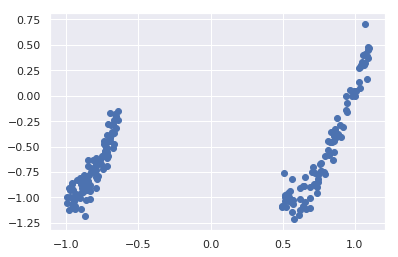

In [7]:
plt.scatter(X,y)

# Model

In [8]:
def activation(x):
    #ReLU: np.maximum(x, 0)
    #TanH: np.tanh(x)
    return np.tanh(x)

In [9]:
def model(X, Y, dim_H):
    
    # dimensions of x and y
    dim_x, dim_y = 1, 1
    # layer 1
    w1 = sample("w1", dist.Normal(np.zeros((dim_x, dim_H)), np.ones((dim_x, dim_H))))  # D_X D_H
    b1 = sample("b1", dist.Normal(np.zeros((X.shape[0], dim_H)), np.ones((X.shape[0], dim_H))))
    z1 = activation(np.matmul(X, w1) + b1)  # N D_H  <= first layer of activations
#    print('Z1', z1.shape)
    # layer 2
    w2 = sample("w2", dist.Normal(np.zeros((dim_H, 1)), np.ones((dim_H, 1))))  # D_X D_H
    b2 = sample("b2", dist.Normal(np.zeros((200, 1)), np.ones((200, 1))))
  #  print('Z2', np.matmul(z1, w2).shape)
    z2 = np.matmul(z1, w2) + b2  # N D_H  <= first layer of activations
    
    # prior on noise
#    prec_obs = sample("prec_obs", dist.Gamma(3.0, 1.0))
    sigma_obs = 0.1

    # observe data
    sample("Y", dist.Normal(z2, sigma_obs), obs=Y)

# Inference

In [10]:
def run_inference(model, data, mcmc_params, rng, dim_H):
    init_params, potential_fn, constrain_fn = initialize_model(rng, model, data[0], data[1], dim_H)
    samples = mcmc(mcmc_params[0], mcmc_params[1] , init_params, sampler='hmc', potential_fn=potential_fn, constrain_fn=constrain_fn)
    return samples

# Parameters visualization

In [11]:
def plot_samples_params(samples):
    w1_samples = samples['w1'].squeeze(-2)
    b1_samples = samples['b1'].squeeze(-2)
    plt.plot(w1_samples)
    plt.plot(b1_samples)

# Prediction

In [12]:
def predict(model, rng, samples, X, dim_H):
    model = substitute(seed(model, rng), samples)
    model_trace = trace(model).get_trace(X=X, Y=None, dim_H=dim_H)
    return model_trace['Y']['value']

# MAIN

## Data visualization

In [13]:
data = [onp.expand_dims(X, axis=1), onp.expand_dims(y, axis=1)]

## Run

In [ ]:
rng, rng_predict = random.split(random.PRNGKey(0))
samples = run_inference(model=model, data=data, mcmc_params=[0, 100], rng=rng, dim_H=50)

/home/mathieu/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:114: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
sample:  37%|███▋      | 37/100 [00:35<00:41,  1.53it/s, 1023 steps of size 1.95e-03. acc. prob=0.94]

In [ ]:
samples.keys()

## Visualization

In [ ]:
loss = []
Y_predict = predict(model, rng, samples, data[0], 1)
for i in range(0, 99):
    loss.append(mean_squared_error(Y_predict[i, :, i], data[1]))
plt.plot(loss)

In [ ]:
Y_predict.shape

In [ ]:
vmap_args = (samples, random.split(rng_predict, 100))
predictions = vmap(lambda samples, rng: predict(model, rng, samples, time_data[0] , 1))(*vmap_args)
predictions = predictions[..., 0]

In [ ]:
predictions

In [ ]:
loss = []
for i in range(0, 1000):
    loss.append(mean_squared_error(predictions[i], time_data[1]))
plt.plot(loss)